In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
df = pd.read_table('~/Documents/video-qoe-labeling/data.txt', delim_whitespace=True, dtype = {'BitRate': np.float64, 'FreezeRatio': np.float64, 'Quality': np.int32})

In [5]:
df['BitRate'] = df['BitRate']/100

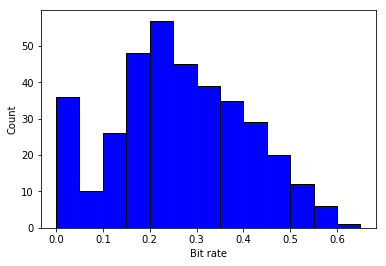

In [7]:
plt.hist(df['BitRate'], bins = [0.05*x for x in range(14)],facecolor='blue', edgecolor = 'black')
plt.xlabel('Bit rate')
plt.ylabel('Count')
plt.show()

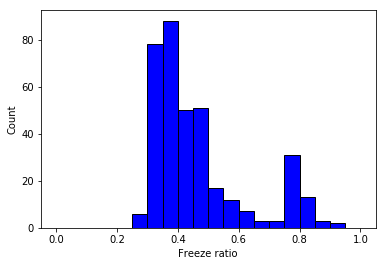

In [8]:
plt.hist(df['FreezeRatio'], bins = [0.05*x for x in range(21)],facecolor='blue', edgecolor = 'black')
plt.xlabel('Freeze ratio')
plt.ylabel('Count')
plt.show()

In [90]:
# get X and y
X, y = np.array(df[['BitRate', 'FreezeRatio']]), np.array(df['Quality'])
accuracies = {}
confusion = {}

In [91]:
# function for performing k-fold cross validation 
def k_Fold_CV(classifier, n):
    accuracies = []
    confusion = []
    kf = KFold(n_splits = n)
    for train, test in kf.split(X):
        predictions = classifier.fit(X[train], y[train]).predict(X[test])
        accuracies.append(classifier.score(X[test], y[test]))
        confusion.append(confusion_matrix(y[test], predictions))
    return (accuracies, confusion)

In [92]:
# decision tree
accuracies['decision_tree'], confusion['decision_tree'] = k_Fold_CV(DecisionTreeClassifier(max_depth = depth), 10)

In [93]:
# k nearest neighbors
params = {'n_neighbors':range(1, 11)}
clf = GridSearchCV(KNeighborsClassifier(), params)
clf.fit(X, y)
clf.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=9, p=2,
           weights='uniform')

In [94]:
# best estimator is n_neighbors = 9 found by grid search
accuracies['nearest_neighbor'], confusion['nearest_neighbor'] = k_Fold_CV(KNeighborsClassifier(n_neighbors = n), 10)

In [95]:
# Naive Bayes classifier
accuracies['naive_bayers'], confusion['naive_bayers'] = k_Fold_CV(GaussianNB(), 10)

In [96]:
# SVM classfier
params = {'kernel':('poly', 'rbf', 'sigmoid'), 'C':[0.1, 1, 10]}
clf = GridSearchCV(SVC(), params)
clf.fit(X, y)
clf.best_estimator_

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [97]:
# best estimator is C = 10, kernel = 'rbg' by grid search
accuracies['svm'], confusion['svm'] = k_Fold_CV(SVC(C = 10, kernel = 'rbf'), 10)

In [98]:
for k, v in accuracies.items():
    print(k)
    print(v)
    print("Average accuracy: {}".format(sum(v)/len(v)))

decision_tree
[0.91891891891891897, 0.86486486486486491, 0.86486486486486491, 0.83783783783783783, 0.91666666666666663, 0.83333333333333337, 0.58333333333333337, 0.44444444444444442, 0.5, 0.63888888888888884]
Average accuracy: 0.7403153153153152
nearest_neighbor
[0.81081081081081086, 0.83783783783783783, 0.7567567567567568, 0.83783783783783783, 0.88888888888888884, 0.97222222222222221, 0.77777777777777779, 0.77777777777777779, 0.63888888888888884, 0.83333333333333337]
Average accuracy: 0.8132132132132132
naive_bayers
[0.94594594594594594, 0.81081081081081086, 0.78378378378378377, 0.72972972972972971, 0.80555555555555558, 0.94444444444444442, 0.80555555555555558, 0.77777777777777779, 0.69444444444444442, 0.75]
Average accuracy: 0.8048048048048049
svm
[0.89189189189189189, 0.86486486486486491, 0.78378378378378377, 0.83783783783783783, 0.86111111111111116, 0.97222222222222221, 0.75, 0.69444444444444442, 0.66666666666666663, 0.86111111111111116]
Average accuracy: 0.8183933933933935
